<a href="https://colab.research.google.com/github/raulsomazabracho/Clusterization/blob/main/Fraude_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA y Desarrollo de Modelo

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importamos las librerías necesarias

In [2]:
#Manipulación, limpieza y visualización de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Preparación de datos y features
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

#Modelos a utilizar
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#Evaluación de modelos
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

#Exportación del modelo
import pickle


### Cargamos el dataset y limpiamos

In [3]:
#Cargamos el dataset
df = pd.read_csv('/content/drive/MyDrive/Data Science/Python/Clusterizaciones (Supervisadas)/Nala/DS Challenge_Nala.csv', sep = ';')

df.sample(5)

,ID_USER,genero,monto,fecha,hora,dispositivo,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude
16587,2431,F,"864,2852851",24/01/2020,8,{'model': 2020; 'device_score': 3; 'os': 'WEB'},Super,Guadalajara,Virtual,43000,63,Aceptada,False,"86,42852851","15,55713513",False
7406,1123,F,"566,8453502",17/01/2020,23,{'model': 2020; 'device_score': 1; 'os': 'WEB'},NaN,NaN,FÃ­sica,43000,50,Aceptada,False,0,"5,668453502",False
23555,3494,F,"637,184793",15/01/2020,9,{'model': 2020; 'device_score': 3; 'os': 'ANDR...,NaN,Toluca,FÃ­sica,93000,63,En proceso,False,0,"6,37184793",False
12915,1923,F,"549,0559734",10/01/2020,22,{'model': 2020; 'device_score': 5; 'os': '%%'},NaN,NaN,FÃ­sica,78000,63,En proceso,False,0,"5,490559734",False
23203,3446,M,"19,76863624",5/01/2020,4,"{'model': 2020; 'device_score': 5; 'os': ','}",Super,Merida,FÃ­sica,69000,52,Aceptada,False,0,"0,197686362",False


In [4]:
#Dividimos la columna de dispositivos
device_cols = df['dispositivo'].str.split(';', n = 2).apply(pd.Series)

device_cols

,0,1,2
0,{'model': 2020,'device_score': 3,'os': 'ANDROID'}
1,{'model': 2020,'device_score': 1,'os': 'ANDROID'}
2,{'model': 2020,'device_score': 1,"'os': ','}"
3,{'model': 2020,'device_score': 3,'os': 'WEB'}
4,{'model': 2020,'device_score': 3,'os': '%%'}
...,...,...,...
26970,{'model': 2020,'device_score': 2,'os': 'ANDROID'}
26971,{'model': 2020,'device_score': 2,'os': 'WEB'}
26972,{'model': 2020,'device_score': 2,'os': 'WEB'}
26973,{'model': 2020,'device_score': 5,"'os': ','}"


In [5]:
#Renombramos columnas
device_cols = device_cols.rename(columns = {0: 'device_model', 1: 'device_score', 2: 'device_os'})

device_cols

,device_model,device_score,device_os
0,{'model': 2020,'device_score': 3,'os': 'ANDROID'}
1,{'model': 2020,'device_score': 1,'os': 'ANDROID'}
2,{'model': 2020,'device_score': 1,"'os': ','}"
3,{'model': 2020,'device_score': 3,'os': 'WEB'}
4,{'model': 2020,'device_score': 3,'os': '%%'}
...,...,...,...
26970,{'model': 2020,'device_score': 2,'os': 'ANDROID'}
26971,{'model': 2020,'device_score': 2,'os': 'WEB'}
26972,{'model': 2020,'device_score': 2,'os': 'WEB'}
26973,{'model': 2020,'device_score': 5,"'os': ','}"


In [6]:
#Las incorporamos al dataset
df = pd.concat([df, device_cols], axis = 1)

In [7]:
#Inspeccionamos con una muestra aleatoria que se hayan agregado correctamente
df.sample(5)

,ID_USER,genero,monto,fecha,hora,dispositivo,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude,device_model,device_score,device_os
5314,811,F,"47,67800145",24/01/2020,15,{'model': 2020; 'device_score': 1; 'os': '%%'},NaN,NaN,FÃ­sica,61000,54,Aceptada,False,0,"0,476780015",False,{'model': 2020,'device_score': 1,'os': '%%'}
7868,1196,M,"279,2330138",5/01/2020,8,{'model': 2020; 'device_score': 4; 'os': '%%'},Restaurante,NaN,FÃ­sica,85000,35,Rechazada,False,"27,92330138","2,513097124",False,{'model': 2020,'device_score': 4,'os': '%%'}
23321,3461,F,"560,5821123",24/01/2020,22,"{'model': 2020; 'device_score': 2; 'os': ','}",Abarrotes,Merida,FÃ­sica,86000,33,Aceptada,False,0,"5,605821123",False,{'model': 2020,'device_score': 2,"'os': ','}"
18730,2762,F,"373,8916078",7/01/2020,9,"{'model': 2020; 'device_score': 5; 'os': ','}",NaN,NaN,FÃ­sica,60000,32,En proceso,False,0,"3,738916078",False,{'model': 2020,'device_score': 5,"'os': ','}"
3860,588,F,"495,6835509",6/01/2020,14,{'model': 2020; 'device_score': 4; 'os': 'ANDR...,Restaurante,NaN,Virtual,45000,34,Rechazada,False,0,"9,913671018",False,{'model': 2020,'device_score': 4,'os': 'ANDROID'}


In [8]:
#Sacamos las columnas que no utilizaremos
df.drop(columns = ['dispositivo', 'ID_USER'],inplace = True, index = 1)

In [9]:
#Comprobamos
df.head()

,genero,monto,fecha,hora,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude,device_model,device_score,device_os
0,F,"608,3456335",21/01/2020,20,Super,Merida,FÃ­sica,71000,51,Aceptada,False,"60,83456335","5,475110702",False,{'model': 2020,'device_score': 3,'os': 'ANDROID'}
2,F,"790,0376533",17/01/2020,11,NaN,Guadalajara,Virtual,94000,56,En proceso,False,0,"15,80075307",False,{'model': 2020,'device_score': 1,"'os': ','}"
3,F,"767,0053873",5/01/2020,11,MPago,Guadalajara,FÃ­sica,94000,56,Aceptada,False,0,"7,670053873",False,{'model': 2020,'device_score': 3,'os': 'WEB'}
4,F,"254,1710526",30/01/2020,10,NaN,Guadalajara,FÃ­sica,94000,56,Aceptada,False,0,"2,541710526",False,{'model': 2020,'device_score': 3,'os': '%%'}
5,F,"37,00374724",27/01/2020,3,NaN,Guadalajara,FÃ­sica,94000,56,Rechazada,False,0,"0,370037472",False,{'model': 2020,'device_score': 2,'os': '%%'}


In [10]:
#Limpiamos nuestras nuevas columnas para ser analizadas más fácilmente
df['device_model'] = df['device_model'].map(lambda x: x.lstrip("{'model':"))
df['device_score'] = df['device_score'].map(lambda x: x.replace("'device_score':",""))
df['device_os'] = df['device_os'].map(lambda x: x.lstrip("'os': '").rstrip("'}"))

df['device_score'] = df['device_score'].astype(int)

In [11]:
#Cambiamos comas por puntos, para mejor manipulación posteriormente
df['cashback'] = df['cashback'].map(lambda x: x.replace(",","."))
df['dcto'] = df['dcto'].map(lambda x: x.replace(",","."))
df['monto'] = df['monto'].map(lambda x: x.replace(",","."))

In [12]:
#Cambiamos tipos de variables
df['cashback'] = df['cashback'].astype(float)
df['dcto'] = df['dcto'].astype(float)
df['monto'] = df['monto'].astype(float)

In [13]:
#Sustituimos
df['tipo_tc'] = df['tipo_tc'].str.replace('FÃ­sica', 'Fisica')

In [14]:
#Ajustamos columna de fecha y creamos columnas para mes y año
df['fecha'] = df['fecha'].astype('datetime64[ns]')
df['mes'] = pd.DatetimeIndex(df['fecha']).month
df['año'] = pd.DatetimeIndex(df['fecha']).year

In [15]:
#Revisamos que no hayan valores anormales
print(df.mes.sort_values().unique())
print(df.año.sort_values().unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12]
[2020]


In [16]:
#Comprobamos que todo esté bien con una muestra aleatoria
df.sample(5)

,genero,monto,fecha,hora,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude,device_model,device_score,device_os,mes,año
7385,M,671.896215,2020-01-18,18,Restaurante,Guadalajara,Fisica,60000,34,Aceptada,False,67.189621,6.047066,False,2020,1,%%,1,2020
10740,M,101.739141,2020-08-01,3,Super,Monterrey,Fisica,54000,54,Aceptada,False,0.000000,1.017391,False,2020,5,WEB,8,2020
14850,F,816.302143,2020-03-01,4,NaN,NaN,Fisica,44000,39,En proceso,False,81.630214,7.346719,False,2020,5,",",3,2020
1520,F,408.262052,2020-01-23,6,Farmacia,Guadalajara,Fisica,90000,56,En proceso,False,0.000000,4.082621,False,2020,3,ANDROID,1,2020
26959,M,18.954647,2020-12-01,22,NaN,NaN,Fisica,79000,37,Aceptada,True,0.000000,0.189546,False,2020,2,%%,12,2020


In [17]:
#Revisamos si hay valores vacíos, estos features no serán incorporados en nuestro modelo
df.isnull().sum()

genero                 0
monto                  0
fecha                  0
hora                   0
establecimiento    10118
ciudad             11678
tipo_tc                0
linea_tc               0
interes_tc             0
status_txn             0
is_prime               0
dcto                   0
cashback               0
fraude                 0
device_model           0
device_score           0
device_os              0
mes                    0
año                    0
dtype: int64

In [18]:
#Revisamos nuestros tipos de variables
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26974 entries, 0 to 26974
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   genero           26974 non-null  object        
 1   monto            26974 non-null  float64       
 2   fecha            26974 non-null  datetime64[ns]
 3   hora             26974 non-null  int64         
 4   establecimiento  16856 non-null  object        
 5   ciudad           15296 non-null  object        
 6   tipo_tc          26974 non-null  object        
 7   linea_tc         26974 non-null  int64         
 8   interes_tc       26974 non-null  int64         
 9   status_txn       26974 non-null  object        
 10  is_prime         26974 non-null  bool          
 11  dcto             26974 non-null  float64       
 12  cashback         26974 non-null  float64       
 13  fraude           26974 non-null  bool          
 14  device_model     26974 non-null  objec

### Análisis Exploratorio de Datos

In [19]:
#Vemos nuestras variables numéricas
numeric_cols = df._get_numeric_data()

numeric_cols.head()

,monto,hora,linea_tc,interes_tc,is_prime,dcto,cashback,fraude,device_score,mes,año
0,608.345633,20,71000,51,False,60.834563,5.475111,False,3,1,2020
2,790.037653,11,94000,56,False,0.000000,15.800753,False,1,1,2020
3,767.005387,11,94000,56,False,0.000000,7.670054,False,3,5,2020
4,254.171053,10,94000,56,False,0.000000,2.541711,False,3,1,2020
5,37.003747,3,94000,56,False,0.000000,0.370037,False,2,1,2020


In [20]:
#Y comenzamos a ver algunas estadísticas 
numeric_cols.describe()

,monto,hora,linea_tc,interes_tc,dcto,cashback,device_score,mes,año
count,26974.000000,26974.000000,26974.000000,26974.000000,26974.000000,26974.000000,26974.000000,26974.000000,26974.0
mean,499.084705,11.987803,62476.495885,48.224772,17.466782,6.261352,3.002669,3.270816,2020.0
std,289.304091,6.642619,21887.237089,9.587418,34.335038,4.458439,1.417406,3.504380,0.0
min,0.017303,1.000000,25000.000000,32.000000,0.000000,0.000138,1.000000,1.000000,2020.0
25%,246.525092,6.000000,44000.000000,40.000000,0.000000,2.792318,2.000000,1.000000,2020.0
50%,500.520141,12.000000,62000.000000,48.000000,0.000000,5.636734,3.000000,1.000000,2020.0
75%,749.598774,18.000000,82000.000000,57.000000,18.777996,8.531822,4.000000,5.000000,2020.0
max,999.917764,23.000000,99000.000000,64.000000,199.356251,19.991582,5.000000,12.000000,2020.0


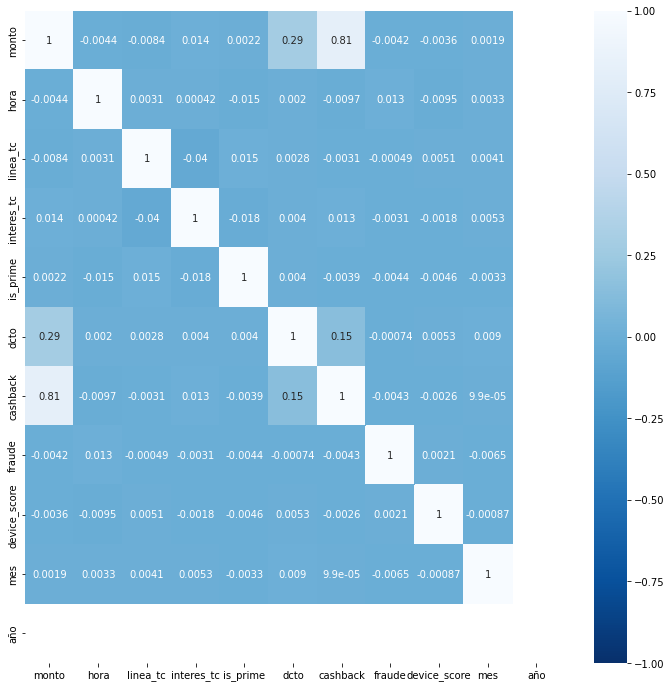

In [21]:
#Observamos si existe alguna correlación en nuestros datos
fig, ax = plt.subplots()
fig.set_size_inches(12,12)

sns.heatmap(numeric_cols.corr(), vmin=-1, vmax=1, annot=True, cmap = 'Blues_r')

No parece haber correlaciones significativas en nuestras variables, salvo entre monto y cashback. Esto no parece indicar uque sean variables de interés para nuestro análisis y/o modelo, sino un indicio de que los datos en nuestro dataset tienen sentido.

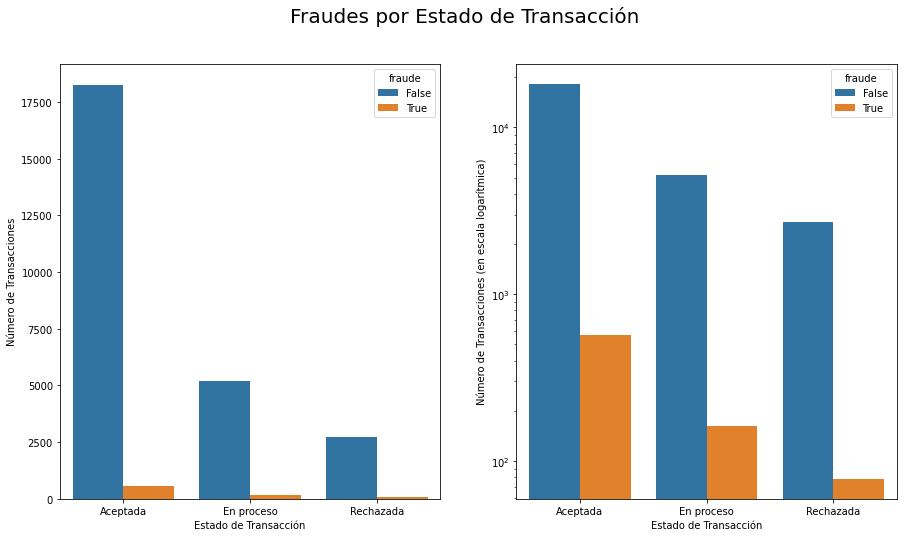

In [22]:
#Observamos la distribución de transacciones fraudulentas por estado de transacción
fig, ax = plt.subplots()
fig.set_size_inches(15,8)

plt.subplot(1,2,1)
status_txn_1 = sns.countplot(data = df, x = 'status_txn', hue = 'fraude')
plt.xlabel('Estado de Transacción')
plt.ylabel('Número de Transacciones')

plt.subplot(1,2,2)
status_txn_2 = sns.countplot(data = df, x = 'status_txn', hue = 'fraude')
status_txn_2.set_yscale('log')
plt.xlabel('Estado de Transacción')
plt.ylabel('Número de Transacciones (en escala logarítmica)')


plt.suptitle('Fraudes por Estado de Transacción', size = 20)
plt.show()

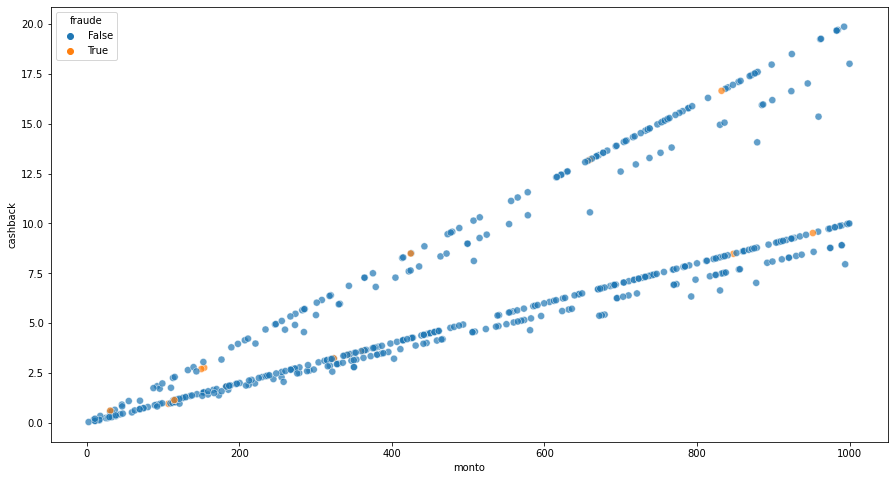

In [23]:
#Observamos si existe relación entre el monto, cashback y fraudes
fig, ax = plt.subplots()
fig.set_size_inches(15,8)

sns.scatterplot(data = df.sample(500), x = 'monto', y = 'cashback',hue = 'fraude', s = 50, alpha = 0.7)

Podemos ver que existe una relación directa entre el monto y el cashback, pero que el cashback no es el mismo para todos los clientes, por lo que crearemos una nueva columna llamada percent_cashback.

In [24]:
#Creamos la nueva columna
df['percent_cashback'] = (df['cashback']/df['monto'])*100
df['percent_cashback'] = df.percent_cashback.round(1)
df.head()

,genero,monto,fecha,hora,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude,device_model,device_score,device_os,mes,año,percent_cashback
0,F,608.345633,2020-01-21,20,Super,Merida,Fisica,71000,51,Aceptada,False,60.834563,5.475111,False,2020,3,ANDROID,1,2020,0.9
2,F,790.037653,2020-01-17,11,NaN,Guadalajara,Virtual,94000,56,En proceso,False,0.000000,15.800753,False,2020,1,",",1,2020,2.0
3,F,767.005387,2020-05-01,11,MPago,Guadalajara,Fisica,94000,56,Aceptada,False,0.000000,7.670054,False,2020,3,WEB,5,2020,1.0
4,F,254.171053,2020-01-30,10,NaN,Guadalajara,Fisica,94000,56,Aceptada,False,0.000000,2.541711,False,2020,3,%%,1,2020,1.0
5,F,37.003747,2020-01-27,3,NaN,Guadalajara,Fisica,94000,56,Rechazada,False,0.000000,0.370037,False,2020,2,%%,1,2020,1.0


In [25]:
#Comprobamos que hay diferentes porcentajes de cashback por transacción
df.percent_cashback.unique()

array([0.9, 2. , 1. , 1.8, 1.6, 0.8])

In [26]:
#Creamos un subset de los fraudes en nuestro dataset
fraudes = df[df['fraude'] == True]

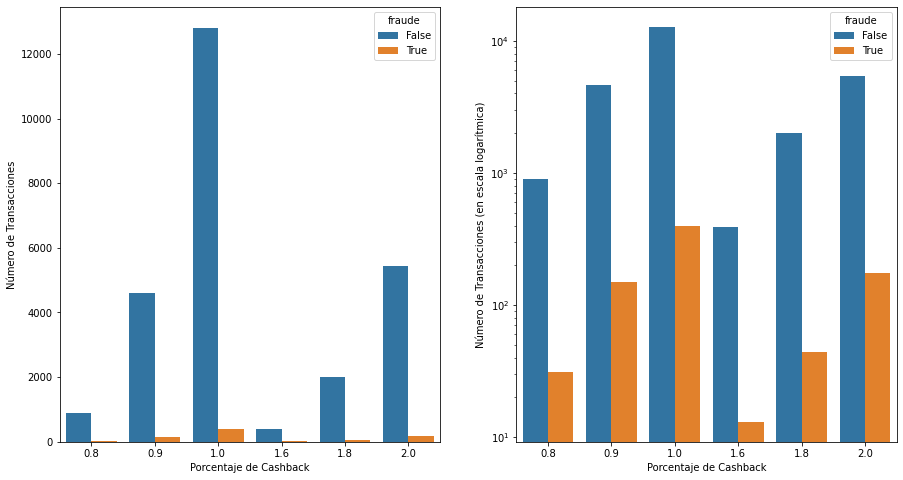

In [27]:
#Observamos la distribución de transacciones por porcentaje de cashback
fig, ax = plt.subplots()
fig.set_size_inches(15,8)

plt.subplot(1,2,1)
count_cashback = sns.countplot(data = df, x = 'percent_cashback', hue = 'fraude')
plt.xlabel('Porcentaje de Cashback')
plt.ylabel('Número de Transacciones')

plt.subplot(1,2,2)
count_cashback = sns.countplot(data = df, x = 'percent_cashback', hue = 'fraude')
plt.xlabel('Porcentaje de Cashback')
plt.ylabel('Número de Transacciones (en escala logarítmica)')
count_cashback.set_yscale('log')

plt.show()

El porcentaje de cashback no parece influir significativamente, el número de fraudes tiende a ser proporcional a la cantidad de transacciones por cashback.

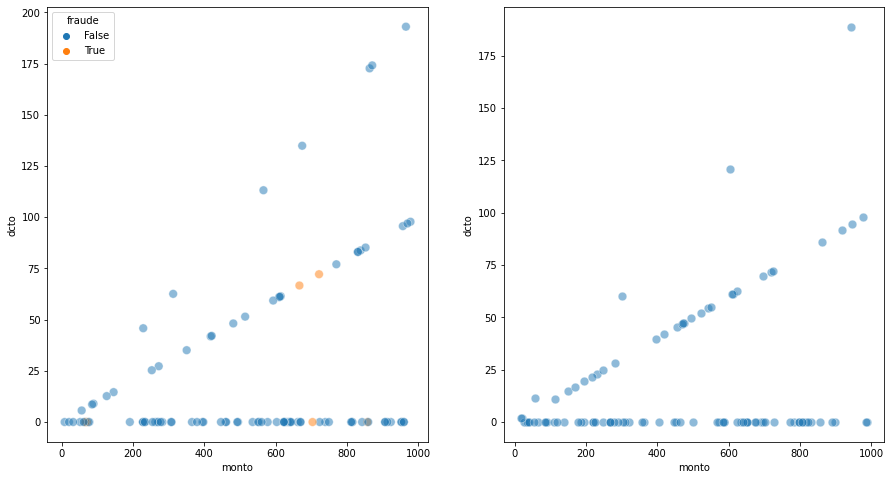

In [28]:
#Realizamos el mismo análisis, pero esta vez con montos y descuentos
fig, ax = plt.subplots()
fig.set_size_inches(15,8)

#df
plt.subplot(1,2,1)
sns.scatterplot(data = df.sample(100), x = 'monto', y = 'dcto', hue = 'fraude',s = 75, alpha = 0.5)

#fraudes
plt.subplot(1,2,2)
sns.scatterplot(data = fraudes.sample(100), x = 'monto', y = 'dcto',s = 75, alpha = 0.5)

Observamos un patrón similar a los gráficos de cashback, por lo que crearemos la misma columna de porcentaje para monto.

In [29]:
#Creamos la columna
df['percent_disc'] = (df['dcto']/df['monto'])*100
df['percent_disc'] = df.percent_disc.round(1)

df.head()

,genero,monto,fecha,hora,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude,device_model,device_score,device_os,mes,año,percent_cashback,percent_disc
0,F,608.345633,2020-01-21,20,Super,Merida,Fisica,71000,51,Aceptada,False,60.834563,5.475111,False,2020,3,ANDROID,1,2020,0.9,10.0
2,F,790.037653,2020-01-17,11,NaN,Guadalajara,Virtual,94000,56,En proceso,False,0.000000,15.800753,False,2020,1,",",1,2020,2.0,0.0
3,F,767.005387,2020-05-01,11,MPago,Guadalajara,Fisica,94000,56,Aceptada,False,0.000000,7.670054,False,2020,3,WEB,5,2020,1.0,0.0
4,F,254.171053,2020-01-30,10,NaN,Guadalajara,Fisica,94000,56,Aceptada,False,0.000000,2.541711,False,2020,3,%%,1,2020,1.0,0.0
5,F,37.003747,2020-01-27,3,NaN,Guadalajara,Fisica,94000,56,Rechazada,False,0.000000,0.370037,False,2020,2,%%,1,2020,1.0,0.0


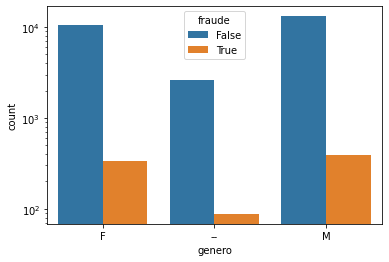

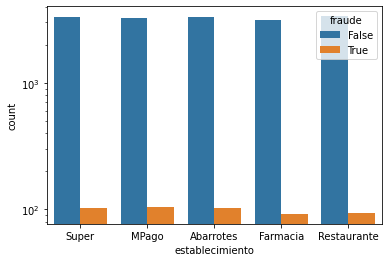

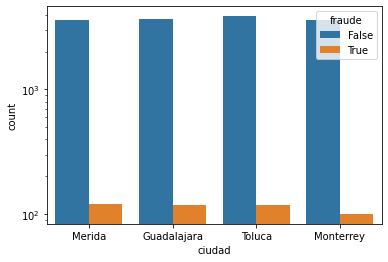

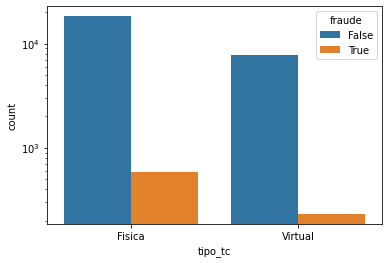

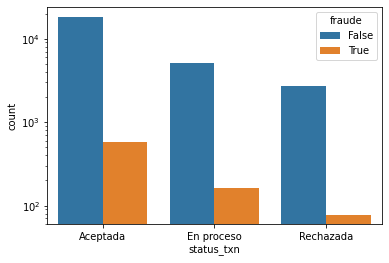

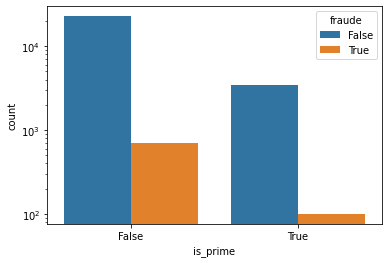

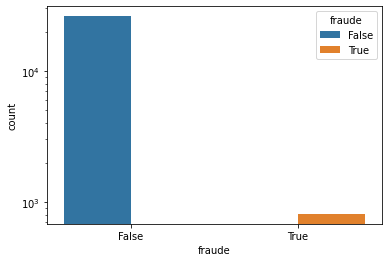

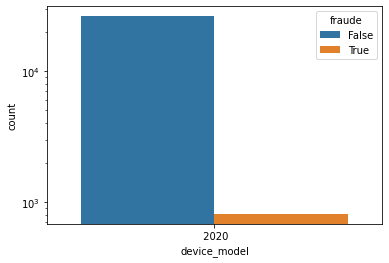

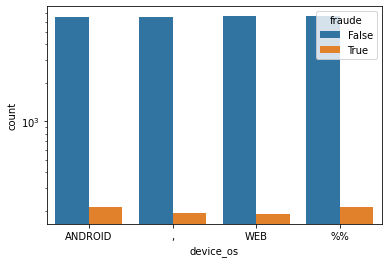

In [30]:
#Observamos si existe algún patrón en nuestras variables categóricas
df_1 = df.select_dtypes(['object','boolean'])

for i, col in enumerate(df_1):
    plt.figure(i)
    chart = sns.countplot(x = col, data = df_1, hue = 'fraude')
    chart.set_yscale('log')

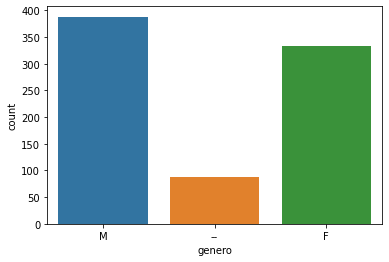

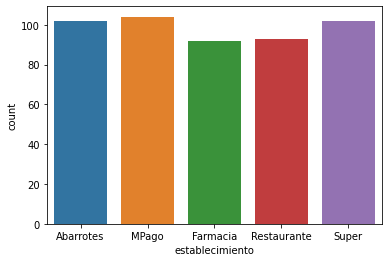

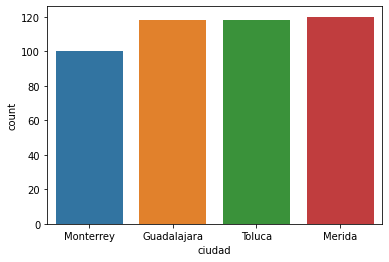

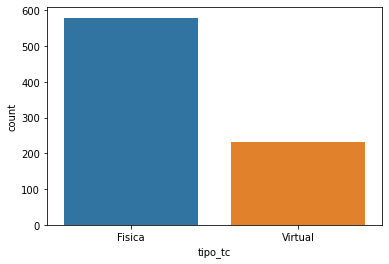

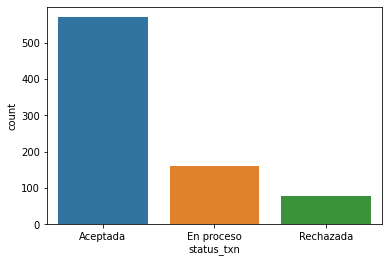

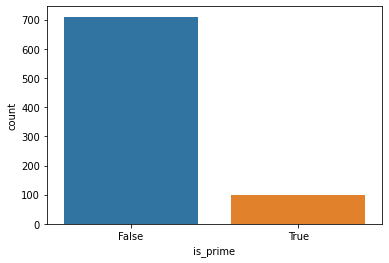

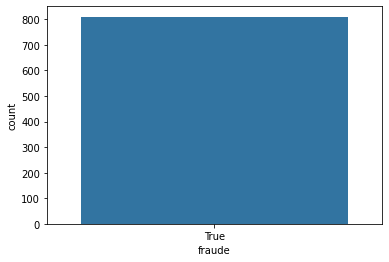

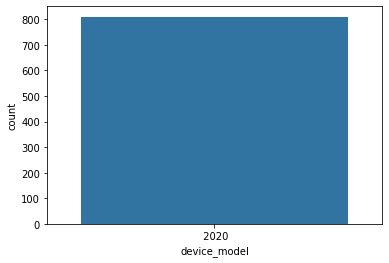

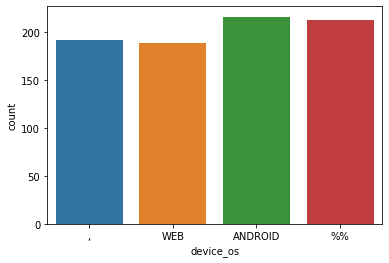

In [31]:
#Hacemos zoom in sólo en los fraudes
fraud_cols = fraudes.select_dtypes(['object','boolean'])

for i, col in enumerate(df_1):
    plt.figure(i)
    sns.countplot(x = col, data = fraud_cols)

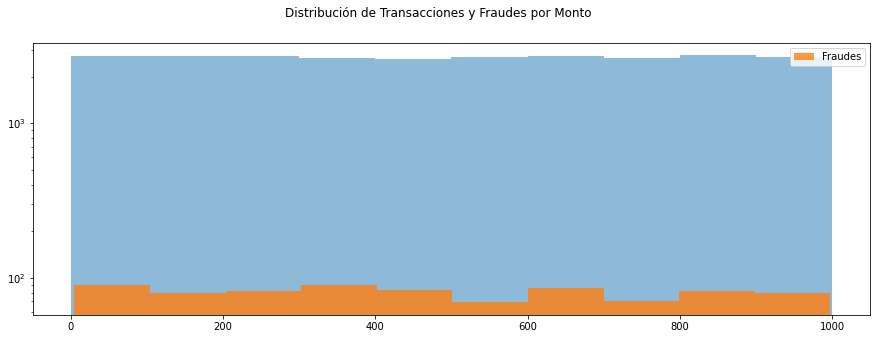

In [32]:
#Observamos cómo se distribuyen las transacciones regulares y fraudulentas por monto
fig, ax = plt.subplots()
fig.set_size_inches(15,5)

ax.hist(df.monto, alpha = 0.5)
ax.hist(fraudes.monto, alpha = 0.8, label = 'Fraudes')
ax.legend()
ax.set_yscale('log')
fig.suptitle('Distribución de Transacciones y Fraudes por Monto')

plt.show()

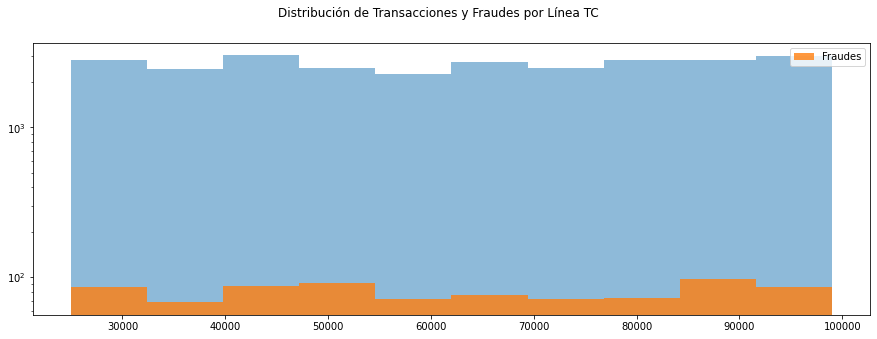

In [33]:
#Mismo para Línea TC
fig, ax = plt.subplots()
fig.set_size_inches(15,5)

ax.hist(df.linea_tc, alpha = 0.5)
ax.hist(fraudes.linea_tc, alpha = 0.8, label = 'Fraudes')
ax.legend()
ax.set_yscale('log')
fig.suptitle('Distribución de Transacciones y Fraudes por Línea TC')

plt.show()

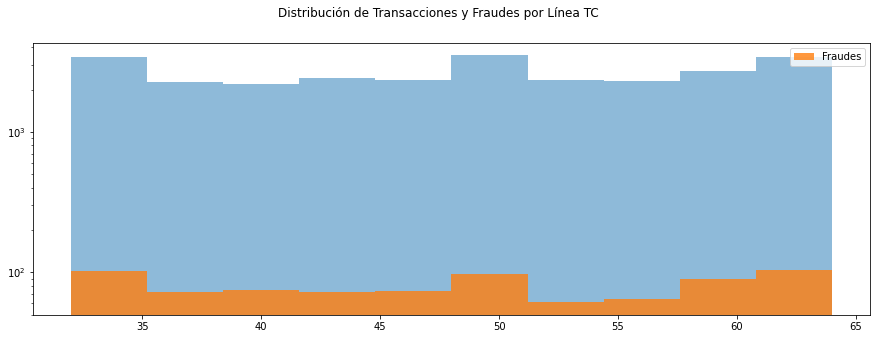

In [34]:
fig, ax = plt.subplots()
fig.set_size_inches(15,5)

ax.hist(df.interes_tc, alpha = 0.5)
ax.hist(fraudes.interes_tc, alpha = 0.8, label = 'Fraudes')
ax.legend()
ax.set_yscale('log')
fig.suptitle('Distribución de Transacciones y Fraudes por Línea TC')

plt.show()

No parecen haber variaciones significativas en ambos gráficos

## Preparación del Dataset y Diseño del Modelo

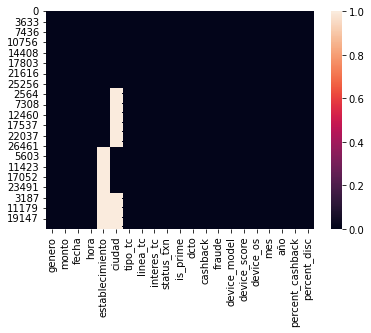

In [35]:
#Graficamos rápidamente los valores faltantes
sns.heatmap(df.isna().sort_values(by = ['establecimiento','ciudad']))

In [36]:
#Observamos qué porcentaje representan del total
null_totals = df.isnull().sum().sort_values(ascending = False)
percent_nulls = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)

missing_df = pd.concat([null_totals, percent_nulls], axis = 1, keys = ['total_nulls', 'percent_total'])

missing_df

,total_nulls,percent_total
ciudad,11678,0.432935
establecimiento,10118,0.375102
percent_disc,0,0.000000
status_txn,0,0.000000
monto,0,0.000000
fecha,0,0.000000
hora,0,0.000000
tipo_tc,0,0.000000
linea_tc,0,0.000000
interes_tc,0,0.000000


In [37]:
#Sacamos las columnas con datos faltantes e irrelevantes
df.drop(columns = ['establecimiento','ciudad', 'device_model'], axis= 1, inplace = True)

In [38]:
#Comprobamos
df.head()

,genero,monto,fecha,hora,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude,device_score,device_os,mes,año,percent_cashback,percent_disc
0,F,608.345633,2020-01-21,20,Fisica,71000,51,Aceptada,False,60.834563,5.475111,False,3,ANDROID,1,2020,0.9,10.0
2,F,790.037653,2020-01-17,11,Virtual,94000,56,En proceso,False,0.000000,15.800753,False,1,",",1,2020,2.0,0.0
3,F,767.005387,2020-05-01,11,Fisica,94000,56,Aceptada,False,0.000000,7.670054,False,3,WEB,5,2020,1.0,0.0
4,F,254.171053,2020-01-30,10,Fisica,94000,56,Aceptada,False,0.000000,2.541711,False,3,%%,1,2020,1.0,0.0
5,F,37.003747,2020-01-27,3,Fisica,94000,56,Rechazada,False,0.000000,0.370037,False,2,%%,1,2020,1.0,0.0


In [39]:
print(df.groupby('fraude').size())

fraude
False    26164
True       810
dtype: int64


In [40]:
#Codificamos la variable objetivo
encoder = OneHotEncoder(sparse = False)

result = encoder.fit_transform(df[['fraude']])
fraud_ = pd.DataFrame(result, columns = list(encoder.categories_[0]))

print(fraud_.value_counts())

df_ml = pd.concat([df, fraud_], axis = 1)

False  True
1.0    0.0     26164
0.0    1.0       810
dtype: int64


In [41]:
#Sacamos la columna de fraude
df_ml.drop(['fraude', False], axis = 1, inplace = True)

In [42]:
#Sacamos nuevamente los campos vacíos
df_ml.dropna(how = 'any', inplace = True)

In [43]:
#Renombramos para una manipulación más sencilla
df_ml = df_ml.rename({True:'is_True'}, axis = 1)

df_ml.head()

,genero,monto,fecha,hora,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,device_score,device_os,mes,año,percent_cashback,percent_disc,is_True
0,F,608.345633,2020-01-21,20.0,Fisica,71000.0,51.0,Aceptada,False,60.834563,5.475111,3.0,ANDROID,1.0,2020.0,0.9,10.0,0.0
2,F,790.037653,2020-01-17,11.0,Virtual,94000.0,56.0,En proceso,False,0.000000,15.800753,1.0,",",1.0,2020.0,2.0,0.0,0.0
3,F,767.005387,2020-05-01,11.0,Fisica,94000.0,56.0,Aceptada,False,0.000000,7.670054,3.0,WEB,5.0,2020.0,1.0,0.0,0.0
4,F,254.171053,2020-01-30,10.0,Fisica,94000.0,56.0,Aceptada,False,0.000000,2.541711,3.0,%%,1.0,2020.0,1.0,0.0,0.0
5,F,37.003747,2020-01-27,3.0,Fisica,94000.0,56.0,Rechazada,False,0.000000,0.370037,2.0,%%,1.0,2020.0,1.0,0.0,0.0


Ahora seleccionaremos las features que incorporaremos a nuestro modelo. En este caso, al ser un prototipo inicial para ser puesto en producción, sólo tomaremos las variables numéricas del dataset.

In [44]:
#Dividimos en Train y Test
x = df_ml[['monto', 'hora', 'percent_disc', 'percent_cashback', 'device_score', 'linea_tc', 'mes']]
y = df_ml[['is_True']]

y.value_counts()

is_True
0.0        26163
1.0          810
dtype: int64

# Resampleo

In [45]:
#RESAMPLEO
df_false_fraud = df[df['fraude'] == False ]
df_true_fraud = df[df['fraude'] == True ]
print(len(df_false_fraud))
print(len(df_true_fraud))

26164
810


In [46]:
df_sample = df_false_fraud.sample(810)

In [47]:
sampled_df = pd.concat([df_true_fraud,df_sample], axis =0, ignore_index = True)

In [48]:
sampled_df.shape

(1620, 18)

In [49]:
sampled_df.head()

,genero,monto,fecha,hora,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude,device_score,device_os,mes,año,percent_cashback,percent_disc
0,M,243.020675,2020-11-01,3,Fisica,33000,54,Aceptada,False,0.000000,2.430207,True,1,",",11,2020,1.0,0.0
1,--,43.721670,2020-04-01,17,Fisica,72000,57,Aceptada,False,0.000000,0.437217,True,1,WEB,4,2020,1.0,0.0
2,F,253.327147,2020-01-14,8,Fisica,62000,45,Aceptada,False,0.000000,2.533271,True,1,WEB,1,2020,1.0,0.0
3,M,19.789476,2020-04-01,16,Fisica,67000,35,Aceptada,False,0.000000,0.197895,True,5,ANDROID,4,2020,1.0,0.0
4,F,705.462887,2020-01-22,9,Fisica,28000,42,Aceptada,False,70.546289,6.349166,True,4,",",1,2020,0.9,10.0


In [50]:
print(sampled_df.fraude.value_counts())

True     810
False    810
Name: fraude, dtype: int64


In [51]:
#Codificamos la variable objetivo
encoder = OneHotEncoder(sparse = False)

result = encoder.fit_transform(sampled_df[['fraude']])
fraud_ = pd.DataFrame(result, columns = list(encoder.categories_[0]))

print(fraud_.value_counts())

df_ml_sampled = pd.concat([sampled_df, fraud_], axis = 1)

#Sacamos la columna de fraude
df_ml_sampled.drop(['fraude', False], axis = 1, inplace = True)

#Sacamos nuevamente los campos vacíos
df_ml_sampled.dropna(how = 'any', inplace = True)

#Renombramos para una manipulación más sencilla
df_ml_sampled = df_ml_sampled.rename({True:'is_True'}, axis = 1)

df_ml.head()

False  True
1.0    0.0     810
0.0    1.0     810
dtype: int64


,genero,monto,fecha,hora,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,device_score,device_os,mes,año,percent_cashback,percent_disc,is_True
0,F,608.345633,2020-01-21,20.0,Fisica,71000.0,51.0,Aceptada,False,60.834563,5.475111,3.0,ANDROID,1.0,2020.0,0.9,10.0,0.0
2,F,790.037653,2020-01-17,11.0,Virtual,94000.0,56.0,En proceso,False,0.000000,15.800753,1.0,",",1.0,2020.0,2.0,0.0,0.0
3,F,767.005387,2020-05-01,11.0,Fisica,94000.0,56.0,Aceptada,False,0.000000,7.670054,3.0,WEB,5.0,2020.0,1.0,0.0,0.0
4,F,254.171053,2020-01-30,10.0,Fisica,94000.0,56.0,Aceptada,False,0.000000,2.541711,3.0,%%,1.0,2020.0,1.0,0.0,0.0
5,F,37.003747,2020-01-27,3.0,Fisica,94000.0,56.0,Rechazada,False,0.000000,0.370037,2.0,%%,1.0,2020.0,1.0,0.0,0.0


# Normalización

## Features numericos

In [62]:
numeric_df = df_ml_sampled[['monto', 'hora', 'linea_tc','interes_tc','dcto','cashback','percent_disc', 'percent_cashback', 'device_score', 'mes']]
print(numeric_df.head())

        monto  hora  linea_tc  ...  percent_cashback  device_score  mes
0  243.020675     3     33000  ...               1.0             1   11
1   43.721670    17     72000  ...               1.0             1    4
2  253.327147     8     62000  ...               1.0             1    1
3   19.789476    16     67000  ...               1.0             5    4
4  705.462887     9     28000  ...               0.9             4    1

[5 rows x 10 columns]


In [63]:
normalized_df = numeric_df
for i in enumerate(numeric_df.columns): 
  normalized_df[i[1]] = (numeric_df[i[1]] - numeric_df [i[1]].mean()) / numeric_df [i[1]].std()

normalized_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,monto,hora,linea_tc,interes_tc,dcto,cashback,percent_disc,percent_cashback,device_score,mes
0,-0.881371,-1.361720,-1.338764,0.645705,-0.487816,-0.847384,-0.593142,-0.575183,-1.424264,2.190204
1,-1.577259,0.738933,0.442646,0.957181,-0.487816,-1.282595,-0.593142,-0.575183,-1.424264,0.207375
2,-0.845384,-0.611486,-0.014126,-0.288725,-0.487816,-0.824877,-0.593142,-0.575183,-1.424264,-0.642409
3,-1.660822,0.588887,0.214260,-1.326980,-0.487816,-1.334856,-0.593142,-0.575183,1.435739,0.207375
4,0.733327,-0.461440,-1.567150,-0.600201,1.512622,0.008404,1.144452,-0.794790,0.720738,-0.642409


## Features Categoricos

In [64]:
categorical_df_columns = df_ml_sampled[['tipo_tc', 'status_txn','is_prime','device_os']]
categorical_df = pd.get_dummies(categorical_df_columns, columns=['tipo_tc', 'status_txn','is_prime','device_os'], drop_first=True)
print(categorical_df.head())

   tipo_tc_Virtual  status_txn_En proceso  ...  device_os_ANDROID  device_os_WEB
0                0                      0  ...                  0              0
1                0                      0  ...                  0              1
2                0                      0  ...                  0              1
3                0                      0  ...                  1              0
4                0                      0  ...                  0              0

[5 rows x 7 columns]


## Union

In [65]:
df_norm = pd.concat([normalized_df,categorical_df], axis =1)
df_norm.head()

,monto,hora,linea_tc,interes_tc,dcto,cashback,percent_disc,percent_cashback,device_score,mes,tipo_tc_Virtual,status_txn_En proceso,status_txn_Rechazada,is_prime_True,"device_os_,",device_os_ANDROID,device_os_WEB
0,-0.881371,-1.361720,-1.338764,0.645705,-0.487816,-0.847384,-0.593142,-0.575183,-1.424264,2.190204,0,0,0,0,1,0,0
1,-1.577259,0.738933,0.442646,0.957181,-0.487816,-1.282595,-0.593142,-0.575183,-1.424264,0.207375,0,0,0,0,0,0,1
2,-0.845384,-0.611486,-0.014126,-0.288725,-0.487816,-0.824877,-0.593142,-0.575183,-1.424264,-0.642409,0,0,0,0,0,0,1
3,-1.660822,0.588887,0.214260,-1.326980,-0.487816,-1.334856,-0.593142,-0.575183,1.435739,0.207375,0,0,0,0,0,1,0
4,0.733327,-0.461440,-1.567150,-0.600201,1.512622,0.008404,1.144452,-0.794790,0.720738,-0.642409,0,0,0,0,1,0,0


# Train_Test_Split

In [66]:
#dividimos traget y features
x = df_norm
y = df_ml_sampled[['is_True']]

#Hacemos test train split
df_ml_dmatrix = xgb.DMatrix(data = x, label = y)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.80, random_state = 48)
x.head()

,monto,hora,linea_tc,interes_tc,dcto,cashback,percent_disc,percent_cashback,device_score,mes,tipo_tc_Virtual,status_txn_En proceso,status_txn_Rechazada,is_prime_True,"device_os_,",device_os_ANDROID,device_os_WEB
0,-0.881371,-1.361720,-1.338764,0.645705,-0.487816,-0.847384,-0.593142,-0.575183,-1.424264,2.190204,0,0,0,0,1,0,0
1,-1.577259,0.738933,0.442646,0.957181,-0.487816,-1.282595,-0.593142,-0.575183,-1.424264,0.207375,0,0,0,0,0,0,1
2,-0.845384,-0.611486,-0.014126,-0.288725,-0.487816,-0.824877,-0.593142,-0.575183,-1.424264,-0.642409,0,0,0,0,0,0,1
3,-1.660822,0.588887,0.214260,-1.326980,-0.487816,-1.334856,-0.593142,-0.575183,1.435739,0.207375,0,0,0,0,0,1,0
4,0.733327,-0.461440,-1.567150,-0.600201,1.512622,0.008404,1.144452,-0.794790,0.720738,-0.642409,0,0,0,0,1,0,0


# Modelos Machine Learning

## Regresión Logistica

In [67]:
#HACEMOS REGRESION LOGISTICA
lr_sampled = LogisticRegression()
lr_sampled.fit(x_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

### Evaluamos el modelo

In [68]:
#imprimimos matriz de confusion de la regresion
from sklearn.metrics import confusion_matrix
#predecimos 
y_predic = lr_sampled.predict(x_test)
pd.DataFrame(confusion_matrix(y_test,y_predic), columns = ['Predecido Normal', 'Predecido Fraude'], index = ['Verdaderamente normal', 'verdaderamente Fraude'])

,Predecido Normal,Predecido Fraude
Verdaderamente normal,80,83
verdaderamente Fraude,85,76


#### ROC/AUC

In [69]:
#Evaluamos el performance
from sklearn import metrics
auc_roc=metrics.roc_auc_score(y_test,y_predic)
print(auc_roc)

0.4814236177266319


In [70]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predic)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.4814236177266319

Text(0.5, 0, 'False Positive Rate')

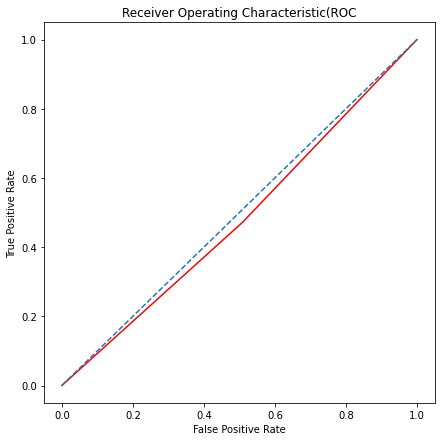

In [71]:
import matplotlib.pyplot as plt
plt.figure(figsize =(7,7))
plt.title("Receiver Operating Characteristic(ROC")
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

#### PRC

In [72]:
#imprimimos el reporte de clasificacion de la regresion
from sklearn.metrics import classification_report

print(classification_report(y_test,y_predic))

              precision    recall  f1-score   support

         0.0       0.48      0.49      0.49       163
         1.0       0.48      0.47      0.47       161

    accuracy                           0.48       324
   macro avg       0.48      0.48      0.48       324
weighted avg       0.48      0.48      0.48       324



Logistica: f1=0.475 auc=0.606
[0.49691358 0.47798742 1.        ]
[1.         0.47204969 0.        ]


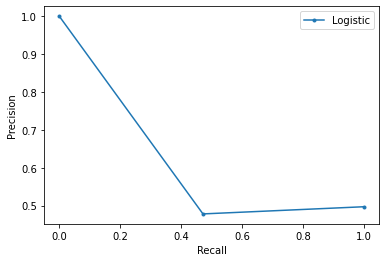

In [73]:
#importamos las librerias
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

#sacamos las metricas
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_predic)
lr_f1, lr_auc = f1_score(y_test, y_predic), auc(lr_recall, lr_precision)
# sumamos los scores e imprimimos
print('Logistica: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
print(lr_precision)
print(lr_recall)
# graficamos el prc
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

## Regresion Logistica Hiperparametros

In [74]:
#Importamos el grid_search y configuramos los parametros
from sklearn.model_selection import GridSearchCV

LR_model = LogisticRegression()

parametros = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] ,
              'penalty':['l1','l2']}

lr_grid = GridSearchCV(LR_model,parametros,cv = 4)


In [75]:
#entrenamos el modelo
lr_grid.fit(x_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

GridSearchCV(cv=4, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']})

### Evaluamos el modelo

In [76]:
#imprimimos matriz de confusion de la regresion
from sklearn.metrics import confusion_matrix
#predecimos 
y_predic = lr_grid.predict(x_test)
pd.DataFrame(confusion_matrix(y_test,y_predic), columns = ['Predecido Normal', 'Predecido Fraude'], index = ['Verdaderamente normal', 'verdaderamente Fraude'])

,Predecido Normal,Predecido Fraude
Verdaderamente normal,84,79
verdaderamente Fraude,81,80


#### ROC/AUC

In [77]:
#Evaluamos el performance
from sklearn import metrics
auc_roc=metrics.roc_auc_score(y_test,y_predic)
print(auc_roc)

0.5061159166253859


In [78]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predic)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5061159166253859

Text(0.5, 0, 'False Positive Rate')

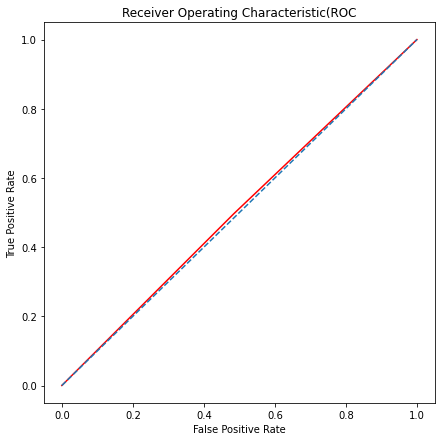

In [79]:
import matplotlib.pyplot as plt
plt.figure(figsize =(7,7))
plt.title("Receiver Operating Characteristic(ROC")
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

#### PRC

In [80]:
#imprimimos el reporte de clasificacion de la regresion
from sklearn.metrics import classification_report

print(classification_report(y_test,y_predic))

              precision    recall  f1-score   support

         0.0       0.51      0.52      0.51       163
         1.0       0.50      0.50      0.50       161

    accuracy                           0.51       324
   macro avg       0.51      0.51      0.51       324
weighted avg       0.51      0.51      0.51       324



## Desicion Tree

In [81]:
#Importamos el modelo
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state = 12)

In [82]:
#Entrenamos
dt.fit(x_train,y_train)

DecisionTreeClassifier(random_state=12)

### Evaluamos el modelo

In [83]:
#imprimimos matriz de confusion de la regresion
from sklearn.metrics import confusion_matrix
#predecimos 
y_predic = dt.predict(x_test)
pd.DataFrame(confusion_matrix(y_test,y_predic), columns = ['Predecido Normal', 'Predecido Fraude'], index = ['Verdaderamente normal', 'verdaderamente fraude'])

,Predecido Normal,Predecido Fraude
Verdaderamente normal,78,85
verdaderamente fraude,74,87


#### ROC/AUC

In [84]:
#Evaluamos el performance
from sklearn import metrics
auc_roc=metrics.roc_auc_score(y_test,y_predic)
print(auc_roc)

0.5094501390847083


In [85]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predic)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5094501390847083

Text(0.5, 0, 'False Positive Rate')

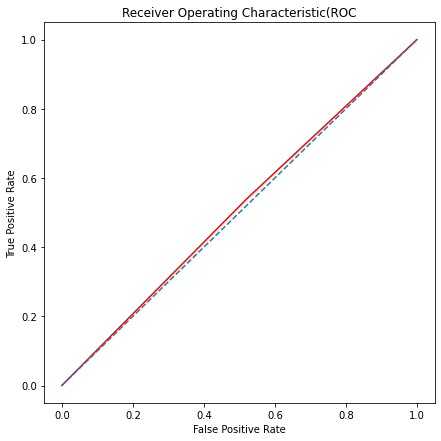

In [86]:
import matplotlib.pyplot as plt
plt.figure(figsize =(7,7))
plt.title("Receiver Operating Characteristic(ROC")
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

#### PRC

In [87]:
#imprimimos el reporte de clasificacion de la regresion
from sklearn.metrics import classification_report

print(classification_report(y_test,y_predic))

              precision    recall  f1-score   support

         0.0       0.51      0.48      0.50       163
         1.0       0.51      0.54      0.52       161

    accuracy                           0.51       324
   macro avg       0.51      0.51      0.51       324
weighted avg       0.51      0.51      0.51       324



Logistica: f1=0.523 auc=0.637
[0.49691358 0.50581395 1.        ]
[1.         0.54037267 0.        ]


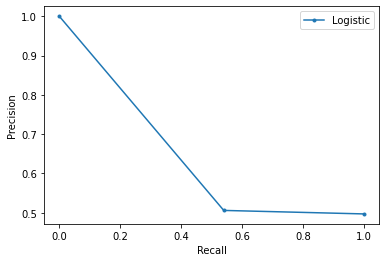

In [88]:
#importamos las librerias
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

#sacamos las metricas
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_predic)
lr_f1, lr_auc = f1_score(y_test, y_predic), auc(lr_recall, lr_precision)
# sumamos los scores e imprimimos
print('Logistica: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
print(lr_precision)
print(lr_recall)
# graficamos el prc
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

## Random Forest

In [ ]:
#Importamos el modelo
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 38, criterion = 'gini', random_state = 45)

In [ ]:
from sklearn.metrics import confusion_matrix

#entrenamos
rf.fit(x_train,y_train)

#predecimos

y_predic= rf.predict(x_test)

### Evaluamos el modelo

In [ ]:
pd.DataFrame(confusion_matrix(y_test,y_predic), columns = ['Predecido Normal', 'Predecido fraude'], index = ['Verdaderamente normal', 'verdaderamente fraude'])

,Predecido Normal,Predecido fraude
Verdaderamente normal,117,82
verdaderamente fraude,109,97


#### ROC/AUC

In [ ]:
#Evaluamos el performance
from sklearn import metrics
auc_roc=metrics.roc_auc_score(y_test,y_predic)
print(auc_roc)

0.5294067424501147


In [ ]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predic)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5294067424501147

Text(0.5, 0, 'False Positive Rate')

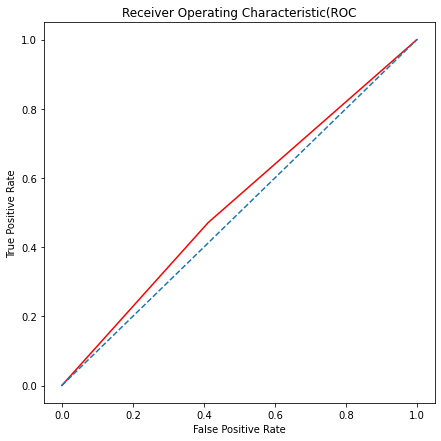

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize =(7,7))
plt.title("Receiver Operating Characteristic(ROC")
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

#### PRC

In [ ]:
#imprimimos el reporte de clasificacion de la regresion
from sklearn.metrics import classification_report

print(classification_report(y_test,y_predic))

              precision    recall  f1-score   support

         0.0       0.52      0.59      0.55       199
         1.0       0.54      0.47      0.50       206

    accuracy                           0.53       405
   macro avg       0.53      0.53      0.53       405
weighted avg       0.53      0.53      0.53       405



Logistica: f1=0.504 auc=0.641
[0.50864198 0.54189944 1.        ]
[1.         0.47087379 0.        ]


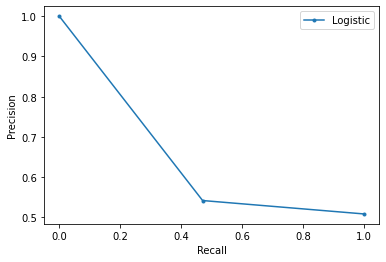

In [ ]:
#importamos las librerias
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

#sacamos las metricas
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_predic)
lr_f1, lr_auc = f1_score(y_test, y_predic), auc(lr_recall, lr_precision)
# sumamos los scores e imprimimos
print('Logistica: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
print(lr_precision)
print(lr_recall)
# graficamos el prc
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

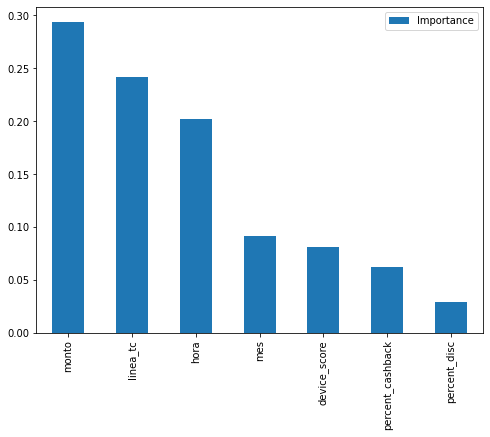

In [ ]:
feat_importances = pd.DataFrame(rf.feature_importances_, x.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

## Random Forest con Hiperparametros

### Configuramos los parametros

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

### Creamos el modelo

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

In [ ]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [ ]:
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

### Evaluamos el modelo

In [ ]:
best_random = rf_random.best_estimator_
print(best_random)

RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                       n_estimators=1200)


In [ ]:
#imprimimos matriz de confusion de la regresion
from sklearn.metrics import confusion_matrix
#predecimos 
y_predic = dt.predict(x_test)
pd.DataFrame(confusion_matrix(y_test,y_predic), columns = ['Predecido Normal', 'Predecido fraude'], index = ['Verdaderamente normal', 'verdaderamente fraude'])

,Predecido Normal,Predecido fraude
Verdaderamente normal,100,99
verdaderamente fraude,106,100


#### ROC/AUC

In [ ]:
#Evaluamos el performance
from sklearn import metrics
auc_roc=metrics.roc_auc_score(y_test,y_predic)
print(auc_roc)

0.4939747280089769


In [ ]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predic)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.4939747280089769

#### PRC

In [ ]:
#imprimimos el reporte de clasificacion de la regresion
from sklearn.metrics import classification_report

print(classification_report(y_test,y_predic))

              precision    recall  f1-score   support

         0.0       0.49      0.50      0.49       199
         1.0       0.50      0.49      0.49       206

    accuracy                           0.49       405
   macro avg       0.49      0.49      0.49       405
weighted avg       0.49      0.49      0.49       405



Logistica: f1=0.494 auc=0.625
[0.50864198 0.50251256 1.        ]
[1.         0.48543689 0.        ]


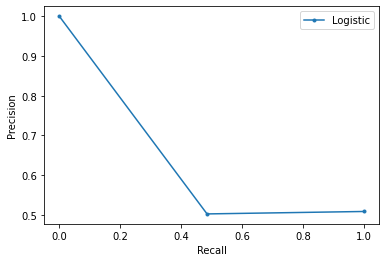

In [ ]:
#importamos las librerias
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

#sacamos las metricas
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_predic)
lr_f1, lr_auc = f1_score(y_test, y_predic), auc(lr_recall, lr_precision)
# sumamos los scores e imprimimos
print('Logistica: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
print(lr_precision)
print(lr_recall)
# graficamos el prc
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
#Observamos nuestro dataset de features

df_ml_dmatrix = xgb.DMatrix(data = x, label = y)

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.75, random_state = 42)

x.head()

,monto,hora,percent_disc,percent_cashback,device_score,linea_tc,mes
0,243.020675,3,0.0,1.0,1,33000,11
1,43.721670,17,0.0,1.0,1,72000,4
2,253.327147,8,0.0,1.0,1,62000,1
3,19.789476,16,0.0,1.0,5,67000,4
4,705.462887,9,10.0,0.9,4,28000,1


In [ ]:
#Entrenamos los modelos a utilizar: Logistic Regression, Random Forest y XGBoost

lr = LogisticRegression()
lr.fit(x_train, y_train.values.ravel())
predict_lr = lr.predict(x_test)
print('Logistic Regression Score: ',lr.score(x_test, y_test))
lr_coef = lr.coef_[0]

random_forest = RandomForestClassifier(n_estimators = 200, max_features= 0.4, max_depth= 10, criterion = 'entropy', random_state= 0)
random_forest.fit(x_train, y_train.values.ravel())
predict_rf = random_forest.predict(x_test)
print('Random Forest Score: ', random_forest.score(x_test, y_test))

xg = xgb.XGBClassifier(n_estimators= 200,max_depth = 5, seed = 0, eval_metric = ['error', 'logloss'], use_label_encoder= False)
xg.fit(x_train, y_train.values.ravel())
predict_xg = xg.predict(x_test)
print('XGBoost Score: ', xg.score(x_test, y_test))

Logistic Regression Score:  0.4962962962962963
Random Forest Score:  0.5259259259259259
XGBoost Score:  0.528395061728395


Podemos ver que el accuracy es demasiado alto, lo que indica un overfit del modelo. Realizaremos una validación cruzada para comprobar esto

In [ ]:
from sklearn.model_selection import cross_val_score

cv_lr = cross_val_score(lr, x_train, y_train.values.ravel(), cv = 10)
cv_rf = cross_val_score(random_forest, x_train, y_train.values.ravel(), cv = 10)
cv_xg = cross_val_score(xg, x_train, y_train.values.ravel(), cv = 10)

print('LR Cross Validation Scores: ',cv_lr)
print('Random Forest Cross Validation Scores: ',cv_rf)
print('Random Forest Cross Validation Scores: ',cv_xg)

LR Cross Validation Scores:  [0.58196721 0.53278689 0.47540984 0.54098361 0.54918033 0.48760331
 0.55371901 0.43801653 0.51239669 0.46280992]
Random Forest Cross Validation Scores:  [0.43442623 0.48360656 0.46721311 0.53278689 0.52459016 0.47107438
 0.44628099 0.52892562 0.43801653 0.51239669]
Random Forest Cross Validation Scores:  [0.45081967 0.50819672 0.50819672 0.54098361 0.48360656 0.43801653
 0.44628099 0.50413223 0.50413223 0.5785124 ]


Ahora armaremos la matriz de confusión para cada modelo

In [ ]:
prediction_lr = lr.predict(x_test)

prediction_rf = random_forest.predict(x_test)

prediction_xg = xg.predict(x_test)

In [ ]:
#Regresión Logística
pd.DataFrame(confusion_matrix(y_test, predict_lr), columns = ['Predicted No', 'Predicted Yes'], index = ['Actual No', 'Actual Yes'])

,Predicted No,Predicted Yes
Actual No,86,113
Actual Yes,91,115


In [ ]:
#Random Forest
pd.DataFrame(confusion_matrix(y_test, predict_rf), columns = ['Predicted No', 'Predicted Yes'], index = ['Actual No', 'Actual Yes'])

,Predicted No,Predicted Yes
Actual No,105,94
Actual Yes,98,108


In [ ]:
#Xgboost
pd.DataFrame(confusion_matrix(y_test, predict_xg), columns = ['Predicted No', 'Predicted Yes'], index = ['Actual No', 'Actual Yes'])

,Predicted No,Predicted Yes
Actual No,114,85
Actual Yes,106,100


In [ ]:
#Evaluamos nuestro modelo
import warnings
warnings.filterwarnings('ignore')

print(classification_report(y_test,predict_lr))

              precision    recall  f1-score   support

         0.0       0.49      0.43      0.46       199
         1.0       0.50      0.56      0.53       206

    accuracy                           0.50       405
   macro avg       0.50      0.50      0.49       405
weighted avg       0.50      0.50      0.49       405



In [ ]:
print(classification_report(y_test,prediction_rf))

              precision    recall  f1-score   support

         0.0       0.52      0.53      0.52       199
         1.0       0.53      0.52      0.53       206

    accuracy                           0.53       405
   macro avg       0.53      0.53      0.53       405
weighted avg       0.53      0.53      0.53       405



In [ ]:
#Vemos las variables con mayor incidencia en el modelo de Regresión Logística, que será el que pondremos en producción
incidencia_lr = pd.DataFrame(lr_coef, 
                     x.columns, 
                     columns=['coef'])\
                    .sort_values(by='coef', ascending=False)

print (incidencia_lr.sort_values(by = 'coef'))

                      coef
percent_disc     -0.014073
mes              -0.008047
percent_cashback -0.000473
linea_tc         -0.000002
monto             0.000122
device_score      0.003704
hora              0.010235


In [ ]:
#Guardamos el modelo
filename = 'logistic_regression_model.pkl'
pickle.dump(lr, open(filename, 'wb'))

In [ ]:
#Comprobamos que se puede cargar y abrir correctamente
loaded_model = pickle.load(open('logistic_regression_model.pkl','rb'))
result = loaded_model.score(x_test, y_test)

result

0.4962962962962963

Por cuestiones de tiempo, no se siguieron realizando pruebas para incrementar la efectividad del modelo, sin embargo, uno de los métodos que se utilizó fue el de normalización.

Puede verse el código utilizado en la sección de Apéndice.

## Apéndice

Para mejorar la efectividad del modelo, se procedió a crear un nuevo dataset con data normalizada. 

De igual manera, el algoritmo siguió memorizando el dataset y se obtuvieron los mismos resultados.


In [ ]:
normalized_df = df[['monto', 'hora', 'percent_disc', 'percent_cashback', 'device_score', 'linea_tc', 'mes']]

In [ ]:

norm = '_norm'
for i in enumerate(normalized_df.columns): 
  normalized_df[i[1]+norm] = (normalized_df[i[1]] - normalized_df[i[1]].mean()) / normalized_df[i[1]].std()

normalized_df.head()

,monto,hora,percent_disc,percent_cashback,device_score,linea_tc,mes,monto_norm,hora_norm,percent_disc_norm,percent_cashback_norm,device_score_norm,linea_tc_norm,mes_norm
0,608.345633,20,10.0,0.9,3,71000,1,0.377668,1.206180,1.133566,-0.788129,-0.001883,0.389428,-0.647994
2,790.037653,11,0.0,2.0,1,94000,1,1.005699,-0.148707,-0.615579,1.665199,-1.412912,1.440269,-0.647994
3,767.005387,11,0.0,1.0,3,94000,5,0.926087,-0.148707,-0.615579,-0.565099,-0.001883,1.440269,0.493435
4,254.171053,10,0.0,1.0,3,94000,1,-0.846561,-0.299250,-0.615579,-0.565099,-0.001883,1.440269,-0.647994
5,37.003747,3,0.0,1.0,2,94000,1,-1.597215,-1.353051,-0.615579,-0.565099,-0.707397,1.440269,-0.647994


In [ ]:
normalized_df.drop(columns = 'linea_tc', axis = 1, inplace = True)

normalized_df.head()

,monto,hora,percent_disc,percent_cashback,device_score,mes,monto_norm,hora_norm,percent_disc_norm,percent_cashback_norm,device_score_norm,linea_tc_norm,mes_norm
0,608.345633,20,10.0,0.9,3,1,0.377668,1.206180,1.133566,-0.788129,-0.001883,0.389428,-0.647994
2,790.037653,11,0.0,2.0,1,1,1.005699,-0.148707,-0.615579,1.665199,-1.412912,1.440269,-0.647994
3,767.005387,11,0.0,1.0,3,5,0.926087,-0.148707,-0.615579,-0.565099,-0.001883,1.440269,0.493435
4,254.171053,10,0.0,1.0,3,1,-0.846561,-0.299250,-0.615579,-0.565099,-0.001883,1.440269,-0.647994
5,37.003747,3,0.0,1.0,2,1,-1.597215,-1.353051,-0.615579,-0.565099,-0.707397,1.440269,-0.647994


In [ ]:
normalized_df = pd.merge(normalized_df, df[['fraude']], left_index= True, right_index = True)

normalized_df

,monto,hora,percent_disc,percent_cashback,device_score,mes,monto_norm,hora_norm,percent_disc_norm,percent_cashback_norm,device_score_norm,linea_tc_norm,mes_norm,fraude
0,608.345633,20,10.0,0.9,3,1,0.377668,1.206180,1.133566,-0.788129,-0.001883,0.389428,-0.647994,False
2,790.037653,11,0.0,2.0,1,1,1.005699,-0.148707,-0.615579,1.665199,-1.412912,1.440269,-0.647994,False
3,767.005387,11,0.0,1.0,3,5,0.926087,-0.148707,-0.615579,-0.565099,-0.001883,1.440269,0.493435,False
4,254.171053,10,0.0,1.0,3,1,-0.846561,-0.299250,-0.615579,-0.565099,-0.001883,1.440269,-0.647994,False
5,37.003747,3,0.0,1.0,2,1,-1.597215,-1.353051,-0.615579,-0.565099,-0.707397,1.440269,-0.647994,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26970,746.192089,13,0.0,1.0,2,8,0.854144,0.152379,-0.615579,-0.565099,-0.707397,-1.026922,1.349507,False
26971,941.804966,15,0.0,1.0,2,1,1.530294,0.453465,-0.615579,-0.565099,-0.707397,-1.026922,-0.647994,False
26972,251.189885,11,0.0,2.0,2,1,-0.856866,-0.148707,-0.615579,1.665199,-0.707397,-1.026922,-0.647994,False
26973,24.182665,17,10.0,0.9,5,1,-1.641532,0.754551,1.133566,-0.788129,1.409145,-1.026922,-0.647994,False
